# **1. Install Modules**

In [61]:
#-- Render Pkgs --#
import os
import panel as pn
import panel.widgets as pnw
import holoviews as hv
import bokeh
from scipy import stats
from holoviews import opts
from holoviews.plotting.links import RangeToolLink
from bokeh.plotting import figure, show
from bokeh.models import CustomJSTickFormatter
from bokeh.models import DatetimeTickFormatter
import hvplot.pandas
import hvplot.dask
from bokeh.plotting import show
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
hv.extension('bokeh')

In [63]:
#@title Decors
#-------------------
# Printer decorator
#-------------------
def _decorator(func):
    def wrap(*args, **kwargs):
        print('#'+'-'*(len(*args)+2))
        func(*args)
        print('#'+'-'*(len(*args)+2))
    return wrap
@_decorator
def printing(msg):
    print('# '+msg)

In [64]:
#@title CowSay
def _decorator(func):
    def wrap(*args, **kwargs):
        print(' '+'-'*(len(*args)+2))
        func(*args)
        print(' '+'-'*(len(*args)+2))
        print("""
        \   ^__^
         \  (oo)\_______
            (__)\       )\/
                ||----w |
                ||     ||
        """)
    return wrap
@_decorator
def cowsay(msg):
    print('<\033[96m '+msg+'\033[00m >')

# **2. Pre Processing**

In [90]:
#-- Reading all Files --#
mainDir = '../Dataset/Darwin/'
listFiles = sorted([os.path.join(root,x) for root,subdir,fili in os.walk(mainDir) for x in fili if x.endswith('.xlsx') and 'Plantilla' in x])
#-- PreProcessing --#
from tqdm.notebook import tqdm
def preProcessing(oBj, kind='fc'):
  idxCol = [1,3] if kind=='fc' else [8,10]
  varname = f'ws_{kind}'
  dfObj = pd.read_excel(oBj, sheet_name='Plantilla Datos').iloc[7:,idxCol]
  dfObj.columns = ['date', varname]
  dfObj.dropna(axis=0, inplace=True)
  dfObj['date'] = pd.to_datetime(dfObj['date'])
  dfObj = dfObj.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name == varname else x)
  #-- Adding Lead and initDate --#
  if kind=='fc':
    dfObj['lead_hour'] = range(1, len(dfObj)+1)
    dfObj['initDate'] = dfObj['date'].min().strftime('%Y-%m-%d')
  return dfObj
#-- Call Function --#
if __name__ == '__main__':
  #-- Iteration through files --#
  containerFc = []
  containerObs = []
  printing('PreProcessing Datasets')
  for n,f in tqdm(enumerate(listFiles), desc='Extracting data', total=len(listFiles)):
    try:
      containerFc.append(preProcessing(f))
      containerObs.append(preProcessing(f, kind='obs'))
    except:
      print(f"Error in {f} file")
  #-- Concating all Fc --#
  dfDarwinFc = pd.concat(containerFc, axis=0, ignore_index=True)
  dfwinObs = pd.concat(containerObs, ignore_index=True).drop_duplicates(subset='date')

#------------------------
# PreProcessing Datasets
#------------------------


Extracting data:   0%|          | 0/337 [00:00<?, ?it/s]

Error in ../Dataset/Darwin/2024/01 Enero/20240120/Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 20012024.xlsx file
Error in ../Dataset/Darwin/2024/01 Enero/20240121/Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 21012024.xlsx file
Error in ../Dataset/Darwin/2024/01 Enero/20240129/Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 29012024.xlsx file
Error in ../Dataset/Darwin/2024/02 Febrero/20240222/Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 22022024.xlsx file
Error in ../Dataset/Darwin/2024/03 Marzo/20240319/~$Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 18032024.xlsx file
Error in ../Dataset/Darwin/2024/03 Marzo/20240320/~$Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 18032024.xlsx file
Error in ../Dataset/Darwin/2024/04 Abril/20240420/~$Plantilla Ejecutado Diario y Predicción Potencia Viento CCE 20042024.xlsx file
Error in ../Dataset/Darwin/2024/04 Abril/20240421/Plantilla Ejecutado Diario y Predicción

## **2.1 Merged Observation (Execute) vs Forecasts Leads**
Excute as observed data

In [93]:
#-- Merging and Categorize --#
dfWindExecu = dfwinObs.rename({'ws_obs':'ws_execute'},axis=1).copy()
dfMergedFcObs = pd.merge(dfDarwinFc, dfWindExecu, on='date', how='outer')
dfMergedFcObs['lead_days'] = pd.cut(dfMergedFcObs['lead_hour'], bins=list(range(0,241,24)), labels=[f'Day {x+1:02d}' for x in range(10)])
dfMergedFcObs.sort_values(['initDate', 'date', 'lead_hour'], inplace=True)
dfMergedFcObs = dfMergedFcObs.rename({'ws_fc':'Darwin'},axis=1)

In [94]:
dfMergedFcObs

,date,Darwin,lead_hour,initDate,ws_execute,lead_days
52,2024-01-03 02:00:00,6.3,1.0,2024-01-03,9.2,Day 01
54,2024-01-03 03:00:00,5.0,2.0,2024-01-03,8.1,Day 01
56,2024-01-03 04:00:00,3.9,3.0,2024-01-03,6.9,Day 01
58,2024-01-03 05:00:00,2.7,4.0,2024-01-03,7.7,Day 01
60,2024-01-03 06:00:00,2.0,5.0,2024-01-03,5.8,Day 01
...,...,...,...,...,...,...
74545,2024-11-24 19:30:00,NaN,NaN,NaN,7.1,NaN
74554,2024-11-24 20:30:00,NaN,NaN,NaN,10.7,NaN
74563,2024-11-24 21:30:00,NaN,NaN,NaN,11.6,NaN
74572,2024-11-24 22:30:00,NaN,NaN,NaN,11.2,NaN


# **3. Read WebScrapping**

In [95]:
#-- Reading webScrapping --#
mainDir = '../Dataset/Scraped_Data/'
sScrapped = sorted([os.path.join(root, x) for root,subdir,files in os.walk(mainDir) for x in files if x.endswith('.xlsx')])
#-- Reading all books --#
dfWindGuru = [pd.read_excel(x, sheet_name='WINDGURU') for x in sScrapped]
dfWindy = [pd.read_excel(x, sheet_name='WINDY') for x in sScrapped]

In [96]:
#-- Concating DataFrame --#
dfWindGuru = pd.concat(dfWindGuru, ignore_index=True)
dfWindy = pd.concat(dfWindy, ignore_index=True)
#-- Convert to Datetime --#
windGuruCols = ['initDate', 'fcDate', 'model', 'wSpeed', 'wGusts', 'Wd']
dfWindGuru.columns = windGuruCols
dfWindGuru['initDate'] = pd.to_datetime(dfWindGuru['initDate'])
dfWindGuru['fcDate'] = pd.to_datetime(dfWindGuru['fcDate'])
#-- Convert to Datime --#
windyCols = ['initDate', 'fcDate', 'model', 'temp', 'wSpeed', 'Wd']
dfWindy.columns = windyCols
dfWindy['initDate'] = pd.to_datetime(dfWindy['initDate'])
dfWindy['fcDate'] = pd.to_datetime(dfWindy['fcDate'])
#-- Convert to float --#
dfWindGuru = dfWindGuru.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name=='wSpeed' else x)
dfWindy = dfWindy.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.name=='wSpeed' else x)

In [97]:
dfWindGuru

,initDate,fcDate,model,wSpeed,wGusts,Wd
0,2024-11-01 17:48:00,2024-11-01 13:00:00,WG,10.0,13,167
1,2024-11-01 17:48:00,2024-11-01 15:00:00,WG,10.0,14,164
2,2024-11-01 17:48:00,2024-11-01 17:00:00,WG,10.0,13,158
3,2024-11-01 17:48:00,2024-11-01 19:00:00,WG,10.0,13,144
4,2024-11-01 17:48:00,2024-11-01 21:00:00,WG,10.0,13,139
...,...,...,...,...,...,...
17495,2024-11-25 05:51:00,2024-12-04 07:00:00,GDPS 15 km,8.0,11,139
17496,2024-11-25 05:51:00,2024-12-04 10:00:00,GDPS 15 km,12.0,15,157
17497,2024-11-25 05:51:00,2024-12-04 13:00:00,GDPS 15 km,12.0,16,161
17498,2024-11-25 05:51:00,2024-12-04 16:00:00,GDPS 15 km,11.0,16,156


# **4. Merging webScrapping vs Engie Dataset**

In [98]:
#-- Get ride of duplicates --#
dfWindGuru = dfWindGuru.groupby(['initDate', 'model'], group_keys=False).apply(lambda x: x.drop_duplicates(subset='fcDate', keep='first'))
dfWindy = dfWindy.groupby(['initDate', 'model'], group_keys=False).apply(lambda x: x.drop_duplicates(subset='fcDate', keep='first'))

In [99]:
#-- Get ride the f** off --#
dfWindGuru['initDateFixed'] = dfWindGuru['initDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfWindy['initDateFixed'] = dfWindy['initDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfWindGurup = dfWindGuru.pivot_table(index=['initDateFixed', 'fcDate'], columns='model', values='wSpeed', aggfunc=np.nanmean).reset_index()
dfWindyp = dfWindy.pivot_table(index=['initDateFixed', 'fcDate'], columns='model', values='wSpeed', aggfunc=np.nanmean).reset_index()

In [109]:
#-- Merge with Observation --#
dfWindGuruObs = pd.merge(dfMergedFcObs, dfWindGurup.rename({'fcDate':'date', 'initDateFixed':'initDate'}, axis=1), on=['date', 'initDate'], how='outer')
dfWindyObs = pd.merge(dfMergedFcObs, dfWindyp.rename({'fcDate':'date', 'initDateFixed':'initDate'}, axis=1), on=['date', 'initDate'], how='outer')

# **5. Panel Plot**

In [110]:
#-- Render Pkgs --#
import panel as pn
import panel.widgets as pnw
import holoviews as hv
import bokeh
from scipy import stats
from holoviews import opts
from holoviews.plotting.links import RangeToolLink
from bokeh.plotting import figure, show
from bokeh.models import CustomJSTickFormatter
from bokeh.models import DatetimeTickFormatter
import hvplot.pandas
import hvplot.dask
from bokeh.plotting import show
# Suppress deprecation warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
hv.extension('bokeh')
%config InlineBackend.figure_format = 'retina'

## **5.1. Dash Main Code**

In [116]:
def addMinMaxMean(arg, *args, **kwargs):
  oBj = arg.copy()
  scolumns = oBj.columns[-4:]
  oBj = oBj.dropna(subset=scolumns, how='all')
  oBj[['min', 'max', kwargs.get('name', 'mean')]] = oBj[scolumns].agg(['min', 'max', 'mean'], axis=1)
  return oBj
#-- Apply Function --#
dfWindGuruObsp = addMinMaxMean(dfWindGuruObs, name='WindGuru Mean Model')
dfWindyObsp = addMinMaxMean(dfWindyObs, name='Windy Mean Model')

In [120]:
dfWindyObsp

,date,Darwin,lead_hour,initDate,ws_execute,lead_days,ECMWF 9km,GFS 22km,ICON 13km,METEOBLUE,min,max,Windy Mean Model
69216,2024-11-02 01:00:00,4.2,24.0,2024-11-01,6.0,Day 01,8.0,9.0,5.0,NaN,5.0,9.0,7.333333
69217,2024-11-02 01:00:00,NaN,NaN,2024-11-02,NaN,NaN,7.0,10.0,7.0,3.5,3.5,10.0,6.875000
69246,2024-11-02 04:00:00,3.3,27.0,2024-11-01,6.7,Day 02,8.0,9.0,4.0,NaN,4.0,9.0,7.000000
69247,2024-11-02 04:00:00,3.4,3.0,2024-11-02,6.7,Day 01,8.0,10.0,6.0,3.5,3.5,10.0,6.875000
69276,2024-11-02 07:00:00,1.3,30.0,2024-11-01,4.0,Day 02,7.0,7.0,2.0,NaN,2.0,7.0,5.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75514,2024-11-30 10:00:00,7.2,129.0,2024-11-25,NaN,Day 06,11.0,10.0,7.0,7.0,7.0,11.0,8.750000
75526,2024-11-30 13:00:00,9.3,132.0,2024-11-25,NaN,Day 06,14.0,12.0,8.0,9.0,8.0,14.0,10.750000
75538,2024-11-30 16:00:00,8.8,135.0,2024-11-25,NaN,Day 06,15.0,12.0,9.0,10.0,9.0,15.0,11.500000
75550,2024-11-30 19:00:00,8.4,138.0,2024-11-25,NaN,Day 06,NaN,12.0,9.0,8.0,8.0,12.0,9.666667


In [119]:
dfWindGuruObsp

,date,Darwin,lead_hour,initDate,ws_execute,lead_days,WG,GDPS 15 km,GFS 13 km,ICON 13 km,min,max,WindGuru Mean Model
69042,2024-11-01 07:00:00,2.6,6.0,2024-11-01,5.2,Day 01,NaN,4.0,NaN,NaN,4.0,4.0,4.00
69072,2024-11-01 10:00:00,4.1,9.0,2024-11-01,10.8,Day 01,NaN,6.0,NaN,NaN,6.0,6.0,6.00
69102,2024-11-01 13:00:00,5.2,12.0,2024-11-01,10.7,Day 01,10.0,10.0,13.0,8.0,8.0,13.0,10.25
69122,2024-11-01 15:00:00,5.9,14.0,2024-11-01,11.7,Day 01,10.0,NaN,13.0,NaN,10.0,13.0,11.50
69132,2024-11-01 16:00:00,5.8,15.0,2024-11-01,9.2,Day 01,NaN,10.0,NaN,8.0,8.0,10.0,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77029,2024-12-10 07:00:00,NaN,NaN,2024-11-25,NaN,NaN,14.0,NaN,14.0,NaN,14.0,14.0,14.00
77030,2024-12-10 10:00:00,NaN,NaN,2024-11-25,NaN,NaN,13.0,NaN,13.0,NaN,13.0,13.0,13.00
77031,2024-12-10 13:00:00,NaN,NaN,2024-11-25,NaN,NaN,13.0,NaN,13.0,NaN,13.0,13.0,13.00
77032,2024-12-10 16:00:00,NaN,NaN,2024-11-25,NaN,NaN,12.0,NaN,12.0,NaN,12.0,12.0,12.00


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
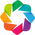

INFO:bokeh.server.server:Starting Bokeh server version 3.6.1 (running on Tornado 6.4.1)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)
DEBUG:bokeh.server.tornado:These host origins can connect to the websocket: ['localhost:43635']
DEBUG:bokeh.server.tornado:Patterns are:
DEBUG:bokeh.server.tornado:  [('/favicon.ico',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ico_handler.IcoHandler'>,
DEBUG:bokeh.server.tornado:    {'app': <bokeh.server.tornado.BokehTornado object at 0x7051759513a0>}),
DEBUG:bokeh.server.tornado:   ('/?',
DEBUG:bokeh.server.tornado:    <class 'panel.io.server.DocHandler'>,
DEBUG:bokeh.server.tornado:    {'application_context': <bokeh.server.contexts.ApplicationContext object at 0x705122ed4320>,
DEBUG:bokeh.server.tornado:     'bokeh_websocket_path': '/ws'}),
DEBUG:bokeh.server.tornado:   ('/ws',
DEBUG:bokeh.server.tornado:    <class 'bokeh.server.views.ws.WSHandler'>,
DEBUG:bokeh.server.tornado:    {'application_c

Launching server at http://localhost:43635


DEBUG:markdown_it.rules_block.code:entering code: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.fence:entering fence: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.blockquote:entering blockquote: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.hr:entering hr: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.list:entering list: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.reference:entering reference: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.html_block:entering html_block: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.heading:entering heading: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.code:entering code: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.fence:entering fence: StateBlock(line=0,l

Opening in existing browser session.


DEBUG:markdown_it.rules_block.code:entering code: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.fence:entering fence: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.blockquote:entering blockquote: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.hr:entering hr: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.list:entering list: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.reference:entering reference: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.html_block:entering html_block: StateBlock(line=0,level=0,tokens=0), 0, 1, False
DEBUG:markdown_it.rules_block.heading:entering heading: StateBlock(line=0,level=0,tokens=0), 0, 1, False
INFO:tornado.access:200 GET / (::1) 292.68ms
INFO:tornado.access:200 GET / (::1) 292.68ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/datatabulator/tabul

In [121]:
import holoviews as hv
import panel as pn
from holoviews.operation.timeseries import rolling
from bokeh.models import Label
import logging
pn.config.js_logs = 'debug'
logging.basicConfig(level=logging.DEBUG)
hv.extension('bokeh')

def myDashBoard(*args, **kwargs):
  #-- Copy DataFrame --#
  dataWindy = dfWindyObs.query("date>=20241101").copy()
  dataWindG = dfWindGuruObs.query("date>=20241101").copy()
  #-- Grid Style --#
  grid={'grid_line_color': 'gray', 'grid_line_width': .8, 'grid_line_dash': 'dotted'}
  #-- Logo --#
  logoUrl = 'https://hamed.energy/wp-content/uploads/2018/12/engie-copy.png'
  logo = pn.pane.PNG(logoUrl, width=200, height=150, align=('center','center'))
  wFarms = ['Punta Lomitas', 'Waira I', 'Cupisnique', 'Talara', 'Huambos', 'Tres Hermanas']
  windFarms = pn.widgets.RadioButtonGroup(name='name', options=wFarms, button_type='success')
  windyModels = ['Windy Mean Model','ECMWF 9km', 'GFS 22km', 'ICON 13km', 'METEOBLUE']
  windyModel = pn.widgets.Select(name='Model', options=windyModels)
  windGModels = ['WindGuru Mean Model', ' WG', 'GDPS 15 km', 'GFS 13 km', 'ICON 13 km']
  windGModel = pn.widgets.Select(name='Model', options=windGModels)
  #-- Principal Panel --#
  @pn.depends(model=windyModel.param.value)
  def get_plot_windy(model):
    #-- Parameters --#
    if model=='Windy Mean Model':
      #- Forecast -#
      hvArea = dfWindyObsp.hvplot.area(x='date', y='min', y2='max', alpha=.1, color='#0E62CB', label='MinMax Model')
    #- Observations -#
    hvMean = dfWindyObsp.hvplot(x='date', y=model, line_width=1.2, color='#0E62CB',
                                grid=True, alpha=.55, label=model)
    hvObs = dataWindy.hvplot(x='date', y='ws_execute', line_width=1.2, color='#c00585',
                              grid=True, alpha=.55, label='Executed')
    hvDarwin = dataWindy.hvplot(x='date', y='Darwin', line_width=1.2, color='green',
                              grid=True, alpha=.55, label='Darwin')

    mainPlot = hvMean * hvObs * hvDarwin if model!='Windy Mean Model' else hvArea * hvMean * hvObs * hvDarwin
    mainPlot = mainPlot.opts(legend_position='top_left', legend_cols=4, legend_offset=(800, 0),
                             fontscale=.95, toolbar='above', ylim=(0, 25), gridstyle=grid, show_grid=True,
                             xlabel="", ylabel="Wind Speed (m/s)")
    return mainPlot
  #-- Principal Panel --#
  @pn.depends(model=windGModel.param.value)
  def get_plot_windg(model):
    #-- Parameters --#
    if model=='WindGuru Mean Model':
      #- Forecast -#
      hvArea = dfWindGuruObsp.hvplot.area(x='date', y='min', y2='max', alpha=.1, color='#0E62CB', label='MinMax Model')
    #- Observations -#
    hvMean = dfWindGuruObsp.hvplot(x='date', y=model, line_width=1.2, color='#0E62CB',
                                   grid=True, alpha=.55, label=model)
    hvObs = dfWindGuruObsp.hvplot(x='date', y='ws_execute', line_width=1.2, color='#c00585',
                                  grid=True, alpha=.55, label='Executed')
    hvDarwin = dfWindGuruObsp.hvplot(x='date', y='Darwin', line_width=1.2, color='green',
                              grid=True, alpha=.55, label='Darwin')

    mainPlot = hvMean * hvObs * hvDarwin if model!='WindGuru Mean Model' else hvArea * hvMean * hvObs * hvDarwin
    mainPlot = mainPlot.opts(legend_position='top_left', legend_cols=4, legend_offset=(800, 0),
                             fontscale=.95, toolbar='above', ylim=(0, 25), gridstyle=grid, show_grid=True,
                             xlabel="", ylabel="Wind Speed (m/s)")
    return mainPlot
  #-- As Block --#
  appRow = pn.WidgetBox(
      pn.Row(logo, pn.WidgetBox('# Short-Term WindSpeed Forecast', windFarms, width=740), sizing_mode='scale_width', styles=dict(background='White')),
      '## Windy Forecast ', pn.Column(windyModel, hv.DynamicMap(get_plot_windy).opts(width=940, height=250, framewise=True)),
      '## WindGuru Forecast ', pn.Column(windGModel, hv.DynamicMap(get_plot_windg).opts(width=940, height=250, framewise=True)),
      )
  return appRow
myDash = myDashBoard()
myDash.show()
# myDash.servable()
myDash.save('test_Beta.html', embed=True)

In [126]:
import pandas as pd
import streamlit as st
import hvplot.pandas  # for hvplot integration in pandas
import holoviews as hv
from bokeh.models import DatetimeTickFormatter
import numpy as np

# -- Reading Pickled --
outDir = '../Outputs/PreProcessing'
dfWindGuruObs = pd.read_pickle(f'{outDir}/preProWindGuru.pkl')
dfWindyObs = pd.read_pickle(f'{outDir}/preProWindy.pkl')

# Function to calculate min, max, mean
def addMinMaxMean(arg, *args, **kwargs):
    oBj = arg.copy()
    scolumns = oBj.columns[-4:]
    oBj = oBj.dropna(subset=scolumns, how='all')
    oBj[['min', 'max', kwargs.get('name', 'mean')]] = oBj[scolumns].agg(['min', 'max', 'mean'], axis=1)
    return oBj

# Apply Function
dfWindGuruObsp = addMinMaxMean(dfWindGuruObs, name='WindGuru Mean Model')
dfWindyObsp = addMinMaxMean(dfWindyObs, name='Windy Mean Model')

# -- Streamlit Dashboard --
st.title("Wind Speed Forecast Dashboard")

# Upload the logo (optional)
logoUrl = 'https://hamed.energy/wp-content/uploads/2018/12/engie-copy.png'
st.image(logoUrl, width=200)

# Selection widgets for wind farms and models
wFarms = ['Punta Lomitas', 'Waira I', 'Cupisnique', 'Talara', 'Huambos', 'Tres Hermanas']
windFarms = st.radio("Select Wind Farm", wFarms)

windyModels = ['Windy Mean Model', 'ECMWF 9km', 'GFS 22km', 'ICON 13km', 'METEOBLUE']
windyModel = st.selectbox("Select Windy Model", windyModels)

windGModels = ['WindGuru Mean Model', 'WG', 'GDPS 15 km', 'GFS 13 km', 'ICON 13 km']
windGModel = st.selectbox("Select WindGuru Model", windGModels)

# Filter data for the dashboard based on wind farm selection
dataWindy = dfWindyObs.query("date>=20241101").copy()
dataWindG = dfWindGuruObs.query("date>=20241101").copy()

# Plotting Windy Model
def plot_windy(model):
    if model == 'Windy Mean Model':
        # Forecast: Min-Max area plot
        plot = dfWindyObsp.hvplot.area(x='date', y='min', y2='max', alpha=0.1, color='#0E62CB', label='MinMax Model')
    else:
        # Observations: Line plot for selected model and observations
        plot = dfWindyObsp.hvplot(x='date', y=model, line_width=1.2, color='#0E62CB', alpha=0.55, label=model)
        plot += dataWindy.hvplot(x='date', y='ws_execute', line_width=1.2, color='#c00585', alpha=0.55, label='Executed')
        plot += dataWindy.hvplot(x='date', y='Darwin', line_width=1.2, color='green', alpha=0.55, label='Darwin')

    # Remove 'legend_position' for Area plot and let Holoviews handle legend
    return plot.opts(xlabel="", ylabel="Wind Speed (m/s)", title=f"Windy Model: {model}")

# Plotting WindGuru Model
def plot_windg(model):
    if model == 'WindGuru Mean Model':
        # Forecast: Min-Max area plot
        plot = dfWindGuruObsp.hvplot.area(x='date', y='min', y2='max', alpha=0.1, color='#0E62CB', label='MinMax Model')
    else:
        # Observations: Line plot for selected model and observations
        plot = dfWindGuruObsp.hvplot(x='date', y=model, line_width=1.2, color='#0E62CB', alpha=0.55, label=model)
        plot += dfWindGuruObsp.hvplot(x='date', y='ws_execute', line_width=1.2, color='#c00585', alpha=0.55, label='Executed')
        plot += dfWindGuruObsp.hvplot(x='date', y='Darwin', line_width=1.2, color='green', alpha=0.55, label='Darwin')

    # Remove 'legend_position' for Area plot and let Holoviews handle legend
    return plot.opts(xlabel="", ylabel="Wind Speed (m/s)", title=f"WindGuru Model: {model}")

# Display plots in Streamlit
st.subheader("Windy Forecast")
st.write(plot_windy(windyModel))

st.subheader("WindGuru Forecast")
st.write(plot_windg(windGModel))


2024-11-25 14:14:10.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.635 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.636 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-25 14:14:10.637 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar